In [86]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import pandas as pd
import itertools 
from matplotlib.backends.backend_pdf import PdfPages
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [87]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [88]:
def read_cs_md(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[] 
        timeseries=np.asarray(riga[2:]).astype(float)
        confd[key2][key]=timeseries
 return(confd)

def read_exp_cs(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[]
        confd[key2][key] += map(float, [float(riga[2])])
 return(confd)

def add_md_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        key2=riga[0]
        timeseries=np.asarray(riga[1:]).astype(float)
        dict[key][key2]=[]
        dict[key][key2]=(timeseries)
  return(dict)

def add_exp_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        key2=riga[0]
        dict[key][key2]=[]
        dict[key][key2] += map(float, [float(riga[1])])
  return(dict)

def add_md_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[1:]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)

def scale_rdc_Q_fit(exp,calc):
     def residuals(p,y,x):
         c = p
         err = ((c*y)-x)
         return err
     p0=0.0001
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c,d=leastsq(residuals,p0,args=(calc,exp))
     fit=c*calc
     #print("Calc:",calc,"Fit:",fit)
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit
    
def scale_rdc_Q(exp,calc):
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c=np.linalg.norm(np.dot(exp,calc))/(np.dot(calc,calc))
     fit=c*calc
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit,c

In [89]:
outdir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/a99SBdisp/reweight/'
datadir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/a99SBdisp/Average_Data/'
expdatadir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/Exp_Data/'

if not os.path.exists(outdir):
    os.makedirs(outdir)

print("outdir",outdir)
print("datadir",datadir)
print("expdata_dir",expdatadir)

outdir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/a99SBdisp/reweight/
datadir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/a99SBdisp/Average_Data/
expdata_dir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/Exp_Data/


In [90]:
expdata=read_exp_cs(expdatadir+'/CS.exp.dat')
compdata=read_cs_md(datadir+'/chemical_shifts.all.csv')

expdata=add_exp_scalar(2.24,expdata,'Rg')
compdata=add_md_scalar(datadir+'/Rgyr-CA.all.csv',compdata,'Rg')

expdata=add_exp_data(expdatadir+'/RDC.exp.dat',expdata,'RDC')
compdata=add_md_data(datadir+'/RDC.all.csv',compdata,'RDC')

expdata=add_exp_data(expdatadir+'/SAXS.exp.dat',expdata,'SAXS')
compdata=add_md_data(datadir+'/SAXS.csv',compdata,'SAXS')

reweight_data_frames=len(compdata['Rg'][0])
print("Reweight Data Frames:",reweight_data_frames)

Reweight Data Frames: 29977


In [91]:
#Set Data For Reweighting and Validation
Reweight_Data=['CA','N']
#Reweight_Data=['CA','CB','H','N','HA','Rg']
Validation_Data=['N']
#STRENGTH OF THE RESTRAINT
#Max+Francesco's Theta
sigma_m=float(50.0)

#Validation_Data=['HA','CA','CB','H','N']
#Reweight_Data=['RDC','JHNHA']
compare=[]
exp_r=[] 
traj_r=[]
err_r=[]
data_r_t=[]
data_r_type={}

traj_v=[]
exp_v=[]
data_v_t=[]
data_v_type={}
err_v=[]

#PREFACTORS FOR ERROR ESTIMATES FOR EACH EXPERIMENTAL DATA
#Prefactors Sigma
err_d = { 'HA': 0.1,
          'CA': 0.2,
          'CB': 0.2,
          'C':  0.2,
          'H':  0.1,
          'HA2': 0.1,
          'HA3': 0.1,
          'N': 0.1 ,
          'RDC': 5.0 ,
          'Rg': 0.01,
          'PRE_2': 0.1,
          'PRE_59': 0.1,
          'SAXS': 0.03,
          'JHNHA': 0.25}

#For Debugging 
compare_dict_r = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { },
          'RDC': {},
          'Rg' : {}, 
          'PRE_2' : {}, 
          'PRE_59' : {}, 
          'SAXS' : {},
          'JHNHA': {}}

#Also For Debugging 
compare_dict_v = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { },
          'RDC': {},
          'JHNHA': {},
          'PRE_2' : {}, 
          'PRE_59' : {},
          'SAXS' : {},        
          'Rg' : {}}

#Process Reweight data into arrays
for key in Reweight_Data:   
 for key2 in expdata[key]:
  #print(key,key2,expdata[key][key2][0])
  #Check if Experimental Value is 0, if not retrieve the MD timeseries 
  if expdata[key][key2][0]!=0:  
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
     compare_dict_r[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_r.append(compdata[key][key2])
     exp_r.append(expdata[key][key2][0])
     err_r.append(err_d[key]) 
     data_r_t.append(str(key))

for key in Reweight_Data: 
   data_id=np.zeros(len(data_r_t)) 
   for i, id in enumerate(data_r_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_r_type[key]=data_id 

#Process Validation data into arrays
for key in Validation_Data:   
 for key2 in expdata[key]:
  if expdata[key][key2][0]!=0:
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
    #This is a hack so it doesn't choke for non-residue specific data read in as an array
    #if np.average(compdata[key][key2][0])!=0:
     compare_dict_v[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_v.append(compdata[key][key2])
     exp_v.append(expdata[key][key2][0])
     err_v.append(err_d[key]) 
     data_v_t.append(str(key))

for key in Validation_Data: 
   data_id=np.zeros(len(data_v_t)) 
   for i, id in enumerate(data_v_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_v_type[key]=data_id 

In [92]:
traj_r=np.asarray(traj_r)
traj_v=np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r=np.asarray(exp_r)
obs_exp_v=np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r=np.asarray(err_r)
err_v=np.asarray(err_v)

#Uniform Initial Weights For Each Frame
weight_bias=np.ones(len(traj_r[0]))
#sigma_m=float(0.1)
# calculate sigma vector
sigma=sigma_m*err_r
#print(sigma)
#number of observables
nobs_r=len(sigma)
nobs_v=len(obs_exp_v)
#number of frames
nframes=len(traj_r[0])

print('# of Frames:',nframes)
#log.write('# of Frames:%s'%nframes+"\n")

print('Reweight Data Points:',nobs_r)
#log.write('Reweight Data Points: %s'%nobs_r+"\n")

for key in data_r_type:
    print(str(key)+':',sum(data_r_type[key]))
    #log.write(str(key)+': %s'%sum(data_r_type[key])+"\n")
    
print('Validation Data Points:',nobs_v)
#log.write('Validation Data Points: %s'%nobs_v+"\n")
for key in data_v_type:
    print(str(key)+':',sum(data_v_type[key]))

# of Frames: 29977
Reweight Data Points: 135
CA: 71.0
N: 64.0
Validation Data Points: 64
N: 64.0


In [93]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f,der)

In [94]:
# perform minimization
#res.X lagrange multiplier
#res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q scaled:", end = '')
      print(" %6.3lf" % qf)

print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

np.savetxt('%s/weights_final.dat'%(outdir),final_weights,fmt=" %6.12lf")
# print final weights to file
f=open("%s/weights_final.a.dat"%outdir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

Initial RMSE reweight data 
 * Total :      9.986
 *    CA :      0.661
 *     N :     14.487
Initial RMSE validation data
 * Total :     14.487
 *     N :     14.487
minimization worked: True
Final RMSE reweight data
 * Total :      9.958
 *    CA :      0.598
 *     N :     14.449
Final RMSE validation data
 * Total :     14.449
 *     N :     14.449
Initial Kish size :  1.000000 29977
Reweighted Kish size :  0.001437 43
Kish ratio :  0.143736


In [95]:
CA_data = []
for x in range(0,71):
    a = traj_r[x]
    CA_data.append(a)

In [96]:
N_data = []
for x in range(71,135):
    a = traj_r[x]
    N_data.append(a)

In [97]:
def hist2d_unbiased(var1,var2):
    plt.figure(figsize=(8,8))
    v1 = var2
    v2 = var1
    free_energy,xedges,yedges=np.histogram2d(v1,v2,30,[[var2.min(),var2.max()],[var1.min(),var1.max()]],normed=True)
    free_energy=-np.log(np.flipud(free_energy)+.000001)
    #free_energy=-(0.001987*T)*free_energy
    im=plt.imshow(free_energy, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
    imaxes = plt.gca()
    plt.title("CA_v_N_unbiased",size=35)
    plt.xlabel("CA_shift", size=20)
    plt.ylabel("N_shift", size=20)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.xticks(size='26')
    plt.yticks(size='26')
    cbar_ticks=[0,1,2,3,4]
    cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)
    cb.set_label("Free Energy / kT",size=15)
    plt.axes(cb.ax)
    plt.clim(vmin=0.1, vmax=4.0)
    plt.tight_layout()

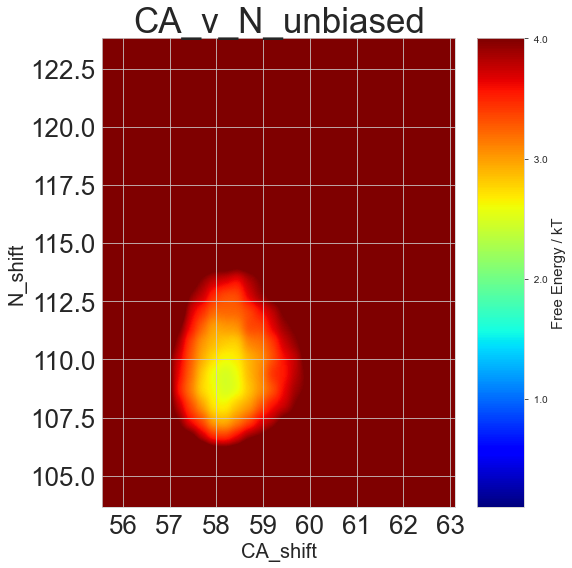

In [98]:
hist2d_unbiased(CA_data[17], N_data[17])

In [132]:
def hist2d_reweighted(var1,var2,weights):
    plt.figure(figsize=(8,8))
    v1 = var2
    v2 = var1
    free_energy,xedges,yedges=np.histogram2d(v1,v2,30,[[var2.min(),var2.max()],[var1.min(),var1.max()]],normed=True,weights=weights)
    free_energy=-np.log(np.flipud(free_energy)+.000001)
    #print(free_energy)
    #free_energy=-(0.001987*T)*free_energy
    im=plt.imshow(free_energy,interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
    imaxes = plt.gca()
    plt.title("CA_v_N_reweighted",size=35)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.xlabel("CA_shift", size=20)
    plt.ylabel("N_shift", size=20)
    plt.xticks(size='26')
    plt.yticks(size='26')
    cbar_ticks=[0,1,2,3,4]
    cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)
    cb.set_label("Free Energy / kT",size=15)
    plt.axes(cb.ax)
    plt.clim(vmin=0.1, vmax=4.0)
    plt.tight_layout()

In [231]:
def hist2d_initial(var1,var2):
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    v1 = var2
    v2 = var1
    free_energy,xedges,yedges=np.histogram2d(v1,v2,30,[[var2.min(),var2.max()],[var1.min(),var1.max()]],normed=True, weights=initial_weights)
    free_energy=-np.log(np.flipud(free_energy)+.000001)
    #print(free_energy)
    #free_energy=-(0.001987*T)*free_energy
    im=ax.imshow(free_energy,interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
    imaxes = plt.gca()
    ax.set_title("CA_v_N_unbiased",size=35)
    ax.tick_params(axis='both', which='major', labelsize=26)
    cbar_ticks=[0,1,2,3,4]
    cb = plt.colorbar(im,ax=ax, format=('% .1f'), aspect=10)
    cb.set_label("Free Energy / kT",size=15)
    #plt.axes(cb.ax)
    #cb.clim(0.1, 4.0)
    plt.tight_layout()

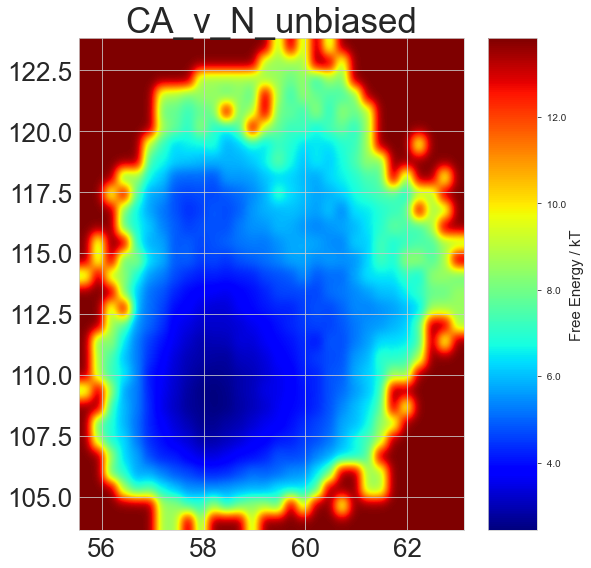

In [232]:
hist2d_initial(CA_data[17], N_data[17])

In [324]:
def hist2d_reweighted(var1,var2,weights):
    fig = plt.figure(figsize=(8,8),constrained_layout = True)
    grid = GridSpec(4, 4, hspace=0, wspace=0)
    ax = fig.add_subplot(grid[:-1, 1:])
    v1 = var2
    v2 = var1
    free_energy,xedges,yedges=np.histogram2d(v1,v2,30,[[var2.min(),var2.max()],[var1.min(),var1.max()]],normed=True,weights=weights)
    free_energy=-np.log(np.flipud(free_energy)+.000001)
    #print(free_energy)
    #free_energy=-(0.001987*T)*free_energy
    im=ax.imshow(free_energy,interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
    #imaxes = plt.gca()
    ax.set_title("CA_v_N_reweighted",size=20)
    ax.tick_params(axis='both', which='major', labelsize=26)
    #cb = plt.colorbar(im,ax=ax, format=('% .1f'), panchor=False, aspect=10, location='right')
    #cb = fig.colorbar(im, ax=ax, format = '%1.2g', location='right',aspect=25, panchor=False)
    #cb.set_label("Free Energy / kT",size=15)
    
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)
    fig.execute_constrained_layout()
    
    x_hist.hist(CA_data[17], 40, histtype='stepfilled',orientation='vertical', color='salmon')
    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='plum')
    y_hist.invert_xaxis()
    
    cb = ax.inset_axes([1.05,0,.08,1],transform = ax.transAxes)
    cbb = fig.colorbar(im,cax=cb,orientation = "vertical")
    
    
    plt.tight_layout()

/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


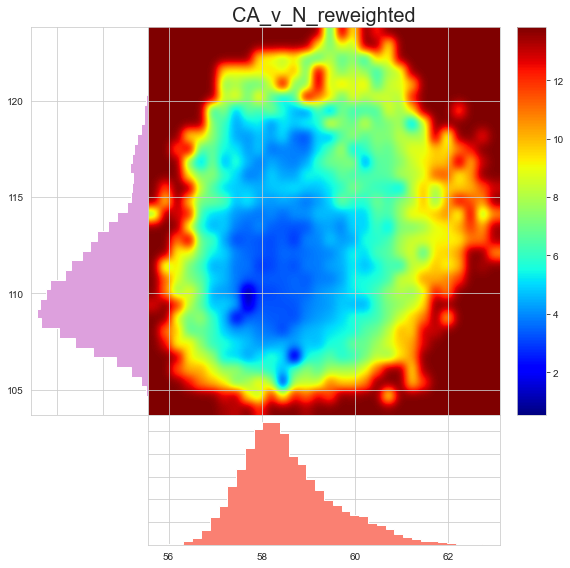

In [325]:
hist2d_reweighted(CA_data[17], N_data[17],final_weights)

In [388]:
def hist2d_sexy(var1,var2,weights):
    ##colors
    color_list = plt.cm.jet
    cs = [color_list(i) for i in range(color_list.N)]
    cmap = colors.ListedColormap(cs)
    boundaries = np.arange(nbins+1).tolist()
    norm = colors.BoundaryNorm(boundaries,cmap.N, clip=True)
    cols = cs[::-round(len(cs)/nbins)]
    ##
    
    
    fig = plt.figure(figsize=(8,8),constrained_layout = True)
    grid = GridSpec(4, 4, hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(grid[:-1, 1:], xticklabels=[], yticklabels=[])
    v1 = var2
    v2 = var1
    free_energy,xedges,yedges=np.histogram2d(v1,v2,nbins,[[var2.min(),var2.max()],[var1.min(),var1.max()]],normed=True,weights=weights)
    free_energy=-np.log(np.flipud(free_energy)+.000001)

    im=ax.imshow(free_energy,interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')

    ax.set_title("CA_v_N_reweighted",size=20)
    ax.tick_params(axis='both', which='major', labelsize=26)

    
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)
    fig.execute_constrained_layout()
    
    xN,xbins,xp = x_hist.hist(CA_data[17], bins = nbins,orientation='vertical')
    idxx = np.argsort(xN)
    yN,ybins,yp= y_hist.hist(y, nbins, orientation='horizontal')
    idxy = yN.argsort()
    
    for j,(ix,iy) in enumerate(zip(idxx,idxy)):
        xp[ix].set_facecolor(cols[j])
        yp[iy].set_facecolor(cols[j])
    
    y_hist.invert_xaxis() 
    cb = ax.inset_axes([1.05,0,.08,1],transform = ax.transAxes)
    cbb = fig.colorbar(im,cax=cb,orientation = "vertical")
    plt.tight_layout()

/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


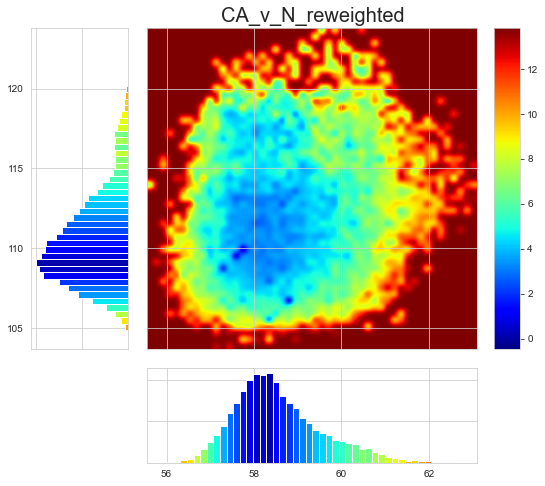

In [389]:
hist2d_sexy(CA_data[17], N_data[17],final_weights)

In [345]:
def hist2d_sexy_works(var1,var2,weights):
    ##colors
    color_list = plt.cm.jet
    cs = [color_list(i) for i in range(color_list.N)]
    cmap = colors.ListedColormap(cs)
    boundaries = np.arange(nbins+1).tolist()
    norm = colors.BoundaryNorm(boundaries,cmap.N, clip=True)
    cols = cs[::-round(len(cs)/nbins)]
    ##
    
    
    fig = plt.figure(figsize=(8,8),constrained_layout = True)
    grid = GridSpec(4, 4, hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(grid[:-1, 1:], xticklabels=[], yticklabels=[])
    v1 = var2
    v2 = var1
    free_energy,xedges,yedges=np.histogram2d(v1,v2,nbins,[[var2.min(),var2.max()],[var1.min(),var1.max()]],normed=True,weights=weights)
    free_energy=-np.log(np.flipud(free_energy)+.000001)

    im=ax.imshow(free_energy,interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')

    ax.set_title("CA_v_N_reweighted",size=20)
    ax.tick_params(axis='both', which='major', labelsize=26)

    
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)
    fig.execute_constrained_layout()
    
    xN,xbins,xp = x_hist.hist(CA_data[17], bins = nbins,orientation='vertical')
    idxx = np.argsort(xN)
    yN,ybins,yp= y_hist.hist(y, nbins, orientation='horizontal')
    idxy = yN.argsort()
    
    for j,(ix,iy) in enumerate(zip(idxx,idxy)):
        xp[ix].set_facecolor(cols[j])
        yp[iy].set_facecolor(cols[j])
    
    y_hist.invert_xaxis() 
    cb = ax.inset_axes([1.05,0,.08,1],transform = ax.transAxes)
    cbb = fig.colorbar(im,cax=cb,orientation = "vertical")
